In [1]:
#
# Example of reading Akatsuki UVI fits file, with highpass filtering
# Adding a part of handling geometry information
# and normalization with incident angle, 2022.09.06
# Toru Kouyama (t.kouyama@aist.go.jp)
#

In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy import ndimage

# Directory and file names
ifldname = "C:/work/Programs/python/akatsuki/"
ifname_uvi = ifldname+ "uvi_20181127_030448_365_l2b_v10.fit"

ifldname_geo = "C:/work/Programs/python/akatsuki/"
ifname_geo = ifldname_geo + "uvi_20181127_030448_365_l3bx_v10.fit"


In [3]:
hdulist_uvi=fits.open(ifname_uvi)
hdulist_uvi.info()

# Because UVI fits file contains actual header & data in extention = 1,
# hdulist_uvi[1] should be selected
hdu_uvi=hdulist_uvi[1]
# header read
header_uvi=hdu_uvi.header
# Show information in a header
header_uvi


Filename: C:/work/Programs/python/akatsuki/uvi_20181127_030448_365_l2b_v10.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  UVI-LEVEL2b    0 ImageHDU       212   (1024, 1024)   float32   


XTENSION= 'IMAGE   '           / type of extension                              
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
PCOUNT  =                    0 / number of parameters per group                 
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'UVI-LEVEL2b'        / name of this HDU                               
EXTVER  =                    0 / version of the extension                       
ORIGIN  = 'VCO/UVI team'       / organization responsible for the data          
DATE    = '2019-11-12T11:36:51' / date of generation of this HDU in UTC         
DATE-BEG= '2018-11-27T03:04:47.718' / date of the start of observation in UTC   
DATE-OBS= '2018-11-27T03:04:

252.99083 -0.30939707


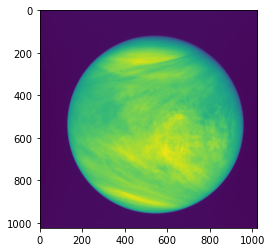

In [4]:

# data read
data_uvi=hdu_uvi.data / 1e6 ## converting unit from W/m3/sr to W/m2/sr/um
print(np.max(data_uvi),np.min(data_uvi))

# Quick Look
udata_akatsuki = np.array(np.clip(data_uvi/np.max(data_uvi)*255,0,255),dtype='u1')
plt.imshow(udata_akatsuki)
plt.show()


In [5]:
#
# Geometry data part
#
#ifldname_geo = "C:/work/Programs/python/akatsuki/"
#ifname_geo = ifldname_geo + "uvi_20181127_030448_365_l3bx_v10.fit"

hdulist_geo=fits.open(ifname_geo)
hdulist_geo.info()

Filename: C:/work/Programs/python/akatsuki/uvi_20181127_030448_365_l3bx_v10.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  Latitude      0 ImageHDU       198   (1024, 1024)   float32   
  2  Longitude     0 ImageHDU       198   (1024, 1024)   float32   
  3  Local time    0 ImageHDU       198   (1024, 1024)   float32   
  4  Phase angle    0 ImageHDU       198   (1024, 1024)   float32   
  5  Incidence angle    0 ImageHDU       198   (1024, 1024)   float32   
  6  Emission angle    0 ImageHDU       198   (1024, 1024)   float32   
  7  Azimuthal angle    0 ImageHDU       198   (1024, 1024)   float32   
  8  Detected limb points    0 BinTableHDU     18   835R x 2C   [1E, 1E]   
  9  Mapped limb points    0 BinTableHDU     18   835R x 2C   [1E, 1E]   
 10  Points on the ellipse    0 BinTableHDU     18   835R x 2C   [1E, 1E]   
 11  Misc.         0 ImageHDU        85   ()      


180.0 0.05375754


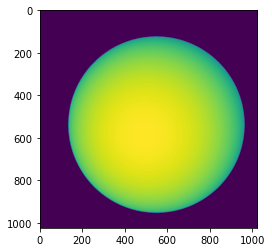

In [6]:
# Geometry data read
hdu_inc=hdulist_geo[5]
tmp_incident_angle=hdu_inc.data
# Convert Nan to 180
incident_angle = np.nan_to_num(tmp_incident_angle, nan=180)

# cos(incident angle) means lambertian diffusion
cos_inc = np.cos(incident_angle/180.*np.pi)
print(np.max(incident_angle),np.min(incident_angle))

# Quick Look
#gdata_akatsuki = np.array(np.clip((incident_angle + 0.)/(180.)*255,0,255),dtype='u1')
gdata_akatsuki = np.array(np.clip((cos_inc + 1.)/(2.)*255,0,255),dtype='u1')
plt.imshow(gdata_akatsuki)
plt.show()

1559.7424 -3.0939708


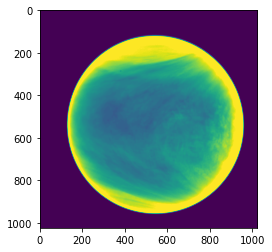

In [7]:
#
# Normalizing UVI image with cos(incident angle)
#
norm_data_uvi = data_uvi / np.clip(cos_inc,0.1,None)
print(np.max(norm_data_uvi),np.min(norm_data_uvi))

# Quick Look
ndata_akatsuki = np.array(np.clip((norm_data_uvi)/(np.max(norm_data_uvi))*255,16,64),dtype='u1')
plt.imshow(ndata_akatsuki)
plt.show()

In [8]:
#
# function for Highpass filtering
#
def higpass_uvi(uvi_image):

    # Estimate Venus radius in UVI image frame
    s_app_radius = 9.71283/2 * np.pi/180 # from value of S_APPDIA in header
    s_IFOV = 0.000204619 # from value of S_IFOV in header

    # considering CCD projection
    radius_v_pix = np.arctan(s_app_radius)/np.arctan(s_IFOV)
    print("Venus radius in image: ",radius_v_pix)

    # Smoothing image with a gussian filter with r/20 sigma
    gauss_sigma = radius_v_pix/20
    s_data_uvi = ndimage.gaussian_filter(uvi_image, gauss_sigma)

    # Subtracting the smoothed image from original image => Highpass filtering
    h_data_uvi = uvi_image-s_data_uvi
    
    return h_data_uvi

Venus radius in image:  413.2476503067004
Venus radius in image:  413.2476503067004


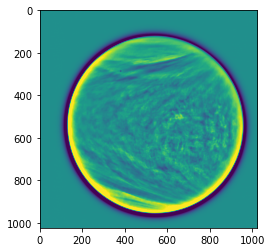

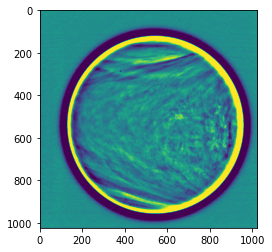

In [9]:
#
# Highpass filtering
#
h_data_uvi = higpass_uvi(data_uvi)
h_norm_data_uvi = higpass_uvi(norm_data_uvi)

# Quick Look
l_value = -30
u_value = 30

u_data_akatsuki = np.array(np.clip( ( h_data_uvi -l_value) /(u_value - l_value) * 255,0,255),dtype='u1')
u_ndata_akatsuki = np.array(np.clip( ( h_norm_data_uvi -l_value) /(u_value - l_value) * 255,0,255),dtype='u1')

plt.imshow(u_data_akatsuki)
plt.show()

plt.imshow(u_ndata_akatsuki)
plt.show()

In [10]:
# Output high-passed data as a fits file which can handle "floating" number

# Generating a fits file with two extentions, each has each layer.
#hdu1 = fits.PrimaryHDU(h_data_uvi)
#hdu2 = fits.ImageHDU(h_norm_data_uvi)

# Generating a fits file with one extention in which two images are integrated into a data cube.
# this format is suite for displaying the data with DS9 (fits viewer)
hdu1 = fits.PrimaryHDU([h_data_uvi,h_norm_data_uvi])

hdulist = fits.HDUList([hdu1])
hdulist.writeto('./new.fits',overwrite=True)